In [1]:
!pip install openpyxl #for loading xlsx files using pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.5 MB/s eta 0:00:00


## Importing Necessary Libraries

In [2]:
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image    
import torch
from torch import optim
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms
from sklearn import metrics
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

src = ".."
device = "cuda:0"
frame_count = 25

#### Loading generated dataframe for Train and Valid set

In [3]:
Train = pd.read_excel("{}/Train.xlsx".format(src))
Valid = pd.read_excel("{}/Valid.xlsx".format(src))

In [4]:
Train.head()

,ID,Path,Modality,Vocal Channel,Emotion,Emotional intensity,Statement,Repetition,Actor
0,01-01-01-01-01-01-01,audio-video/Actor_01/01-01-01-01-01-01-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,1st repetition,1
1,01-01-01-01-01-02-01,audio-video/Actor_01/01-01-01-01-01-02-01.mp4,full-AV,speech,neutral,normal,Kids are talking by the door,2nd repetition,1
2,01-01-01-01-02-01-01,audio-video/Actor_01/01-01-01-01-02-01-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,1st repetition,1
3,01-01-01-01-02-02-01,audio-video/Actor_01/01-01-01-01-02-02-01.mp4,full-AV,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,1
4,01-01-02-01-01-01-01,audio-video/Actor_01/01-01-02-01-01-01-01.mp4,full-AV,speech,calm,normal,Kids are talking by the door,1st repetition,1


In [5]:
emotion = {
    "neutral": 0, 
    "calm": 1, 
    "happy": 2, 
    "sad": 3, 
    "angry": 4, 
    "fearful": 5, 
    "disgust": 6, 
    "surprised": 7
}

reverse_emotion = {y: x for x, y in emotion.items()}

## Initializing custom Dataset class

#### Stacking frames per video for Resnet18Rnn

In [6]:
class myDataset(Dataset):
    def __init__(self, df, path, frame_count, emotion, transform=None):
        self.df = df
        self.path = path
        self.frame_count = frame_count
        self.emotion = emotion
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        directory = "{}/{}".format(self.path, self.df["ID"].iloc[idx]) #name of a video
        files = ["{}/{}".format(directory, x) for x in os.listdir(directory)] #list of all stored frames in a given video
        frames = []
        for file in files[:self.frame_count]:
            image = Image.open(file)
            image = self.transform(image)
            frames.append(image) #appending frame to list
        imgs_tensor = torch.stack(frames) #(3, 25, 112, 112)
        label = self.emotion[self.df["Emotion"].iloc[idx]]  #converting label to index
        
        return imgs_tensor, label

#### Instantiating dataset and dataloader, and using a simple transform for marking baseline performance

In [7]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225]
            )
]) 

src = "../frames"
trainset = myDataset(Train, src, frame_count, emotion, transform)
validset = myDataset(Valid, src, frame_count, emotion, transform)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
validloader = DataLoader(validset, batch_size=2, shuffle=False)

In [8]:
image, label = next(iter(trainloader)) #verifying shape of image and label from dataloader
print(image.shape, label.shape)

torch.Size([4, 25, 3, 224, 224]) torch.Size([4])


## Initializing custom Model class

#### We used a Resnet18 model that had been pre-trained on the ImageNet dataset as the feature extractor. The extracted features were then fed to an RNN layer to extract the temporal correlation. The output of the RNN layer was fed to a fully connected layer to get the classification output.

In [9]:
class Resnet18Rnn(nn.Module):
    def __init__(self, config):
        super(Resnet18Rnn, self).__init__()
        num_classes = config["num_classes"]
        dropout = config["dropout"]
        rnn_hidden_size = config["rnn_hidden_size"]
        rnn_num_layers = config["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=True) #backbone convolutional network
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity() #passing identity to the subsequent layer
        
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dropout)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers) #rnn
        self.fc = nn.Linear(rnn_hidden_size, num_classes) #replacing final layer with linear layer for custom num_classes
    
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        #passing frames one by one through the rnn 
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1]) #regularization using dropout
        out = self.fc(out) #passing output vector from rnn to through a dense layer
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

## Defining configuration for training

In [10]:
config = {  
    "epochs": 15,
    "path2weights": "/kaggle/working/best.pt",
    "num_classes": len(emotion.keys()),
    "dropout": 0.1,
    "pretrained" : True,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
    "trainloader": trainloader,
    "validloader": validloader,
    "sanity_check": False,
}

## Defining functions for training model

In [11]:
def trainModel(model, criterion, optimizer, scheduler, config):
    epochs=config["epochs"]
    trainloader=config["trainloader"]
    validloader=config["validloader"]
    sanity_check=config["sanity_check"]
    path2weights=config["path2weights"]
    
    #for plotting
    loss_history={
        "train": [],
        "val": [],
    }
    #for plotting
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(epochs):
        current_lr=get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, epochs-1, current_lr))
        model.train() #for training
        train_loss, train_metric = oneEpoch(model, criterion, trainloader, sanity_check, optimizer) #one training epoch
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval() #for validation
        with torch.no_grad():
            val_loss, val_metric = oneEpoch(model, criterion, validloader, sanity_check) #one validation epoch
        #saving weights from best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        #updating learning rate scheduler
        scheduler.step(val_loss)
        if current_lr != get_lr(optimizer):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        print("Train Loss: %.6f, Val Loss: %.6f, Val Acc: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 
    #reloading best weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history


# get learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#get metrics for a batch
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True) #picking highest probability index
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

#performing backward propagation
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), metric_b
        
#iterating through all batches in a given epoch
def oneEpoch(model, criterion, dataloader, sanity_check=False, optimizer=None):
    running_loss, running_metric = 0.0, 0.0
    len_data = len(dataloader.dataset)
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
        output = model(inputs)
        loss_b, metric_b = loss_batch(criterion, output, labels, optimizer)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

## Starting training

In [12]:
model = Resnet18Rnn(config)  #instantiating model
model.to(device) #shifting model to gpu from cpu
criterion = nn.CrossEntropyLoss(reduction="sum") #loss function
optimizer = optim.Adam(model.parameters(), lr=3e-4) #optimizer
scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=5,verbose=1) #learning rate scheduler
model, loss_history, metric_history = trainModel(model, criterion, optimizer, scheduler, config)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/14, current lr = 0.0003
Copied best model weights!
Train Loss: 1.612164, Val Loss: 1.701632, Val Acc: 43.96
----------
Epoch 1/14, current lr = 0.0003
Copied best model weights!
Train Loss: 1.203261, Val Loss: 1.471352, Val Acc: 48.12
----------
Epoch 2/14, current lr = 0.0003
Train Loss: 0.922868, Val Loss: 1.646723, Val Acc: 40.42
----------
Epoch 3/14, current lr = 0.0003
Train Loss: 0.710700, Val Loss: 1.722182, Val Acc: 45.83
----------
Epoch 4/14, current lr = 0.0003
Train Loss: 0.536965, Val Loss: 1.676668, Val Acc: 50.00
----------
Epoch 5/14, current lr = 0.0003
Train Loss: 0.377825, Val Loss: 2.035226, Val Acc: 42.08
----------
Epoch 6/14, current lr = 0.0003
Train Loss: 0.295682, Val Loss: 2.249023, Val Acc: 40.21
----------
Epoch 7/14, current lr = 0.0003
Epoch     8: reducing learning rate of group 0 to 1.5000e-04.
Loading best model weights!
Train Loss: 0.198581, Val Loss: 2.334355, Val Acc: 40.83
----------
Epoch 8/14, current lr = 0.00015
Train Loss: 0.811404, V

## Plotting Graphs

In [13]:
def plot_loss(loss_hist, metric_hist):

    epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1, epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1, epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1, epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1, epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

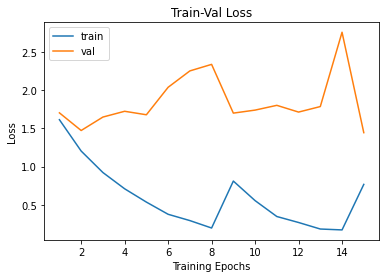

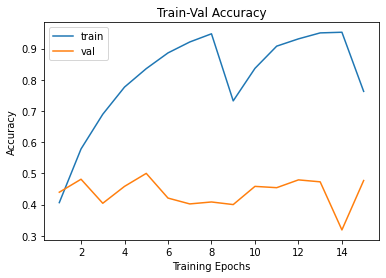

In [14]:
plot_loss(loss_history, metric_history)

#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set

In [15]:
testset = myDataset(Valid, src, frame_count, emotion, transform)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

lbl_list, out_list = [], []
for inputs, labels in tqdm(testloader):
    inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
    output = model(inputs).argmax(dim=1, keepdim=True) #picking highest probability index
    lbl_list.extend(labels)
    out_list.extend(output)

pred = [reverse_emotion[x.item()] for x in out_list]
true = [reverse_emotion[x.item()] for x in lbl_list]

print("CONFUSION MATRIX\n")
print(metrics.confusion_matrix(true, pred))
print("\n\nCLASSIFICATION REPORT\n")
print(metrics.classification_report(true, pred, digits=3));

100%|██████████| 240/240 [01:35<00:00,  2.52it/s]

CONFUSION MATRIX

[[30  9  6  0  0  8  8  3]
 [ 0 42  0  0  5 14  0  3]
 [12  0 31  2  0  4 10  5]
 [ 8  2  2 33  0  2 10  7]
 [ 0 22  0  0 38  0  0  4]
 [ 3 12  0  0  0 10  0  7]
 [ 4  6  6  2  2 12 32  0]
 [ 4 12  0 20  0  5 10 13]]


CLASSIFICATION REPORT

              precision    recall  f1-score   support

       angry      0.492     0.469     0.480        64
        calm      0.400     0.656     0.497        64
     disgust      0.689     0.484     0.569        64
     fearful      0.579     0.516     0.545        64
       happy      0.844     0.594     0.697        64
     neutral      0.182     0.312     0.230        32
         sad      0.457     0.500     0.478        64
   surprised      0.310     0.203     0.245        64

    accuracy                          0.477       480
   macro avg      0.494     0.467     0.468       480
weighted avg      0.515     0.477     0.484       480



#### Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for Validation Set with respect to each sentence

In [16]:
statements = ["Kids are talking by the door", "Dogs are sitting by the door"]

for statement in statements: 
    Test = Valid[Valid["Statement"] == statement]
    testset = myDataset(Test, src, frame_count, emotion, transform)
    testloader = DataLoader(testset, batch_size=2, shuffle=False)

    lbl_list, out_list = [], []
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device) #shifting data to gpu from cpu
        output = model(inputs).argmax(dim=1, keepdim=True) #picking highest probability index
        lbl_list.extend(labels)
        out_list.extend(output)

    pred = [reverse_emotion[x.item()] for x in out_list]
    true = [reverse_emotion[x.item()] for x in lbl_list]

    print("CONFUSION MATRIX for '{}'\n".format(statement))
    print(metrics.confusion_matrix(true, pred))
    print("\n\nCLASSIFICATION REPORT for '{}'\n".format(statement))
    print(metrics.classification_report(true, pred, digits=3));
    print("\n\n")

100%|██████████| 120/120 [00:46<00:00,  2.57it/s]


CONFUSION MATRIX for 'Kids are talking by the door'

[[13  4  6  0  0  2  6  1]
 [ 0 23  0  0  4  4  0  1]
 [ 4  0 11  1  0  4  8  4]
 [ 2  0  2 17  0  0  6  5]
 [ 0 10  0  0 20  0  0  2]
 [ 1  8  0  0  0  2  0  5]
 [ 2  4  2  0  0  4 20  0]
 [ 2  6  0 10  0  1  5  8]]


CLASSIFICATION REPORT for 'Kids are talking by the door'

              precision    recall  f1-score   support

       angry      0.542     0.406     0.464        32
        calm      0.418     0.719     0.529        32
     disgust      0.524     0.344     0.415        32
     fearful      0.607     0.531     0.567        32
       happy      0.833     0.625     0.714        32
     neutral      0.118     0.125     0.121        16
         sad      0.444     0.625     0.519        32
   surprised      0.308     0.250     0.276        32

    accuracy                          0.475       240
   macro avg      0.474     0.453     0.451       240
weighted avg      0.498     0.475     0.473       240






100%|██████████| 120/120 [00:47<00:00,  2.55it/s]

CONFUSION MATRIX for 'Dogs are sitting by the door'

[[17  5  0  0  0  6  2  2]
 [ 0 19  0  0  1 10  0  2]
 [ 8  0 20  1  0  0  2  1]
 [ 6  2  0 16  0  2  4  2]
 [ 0 12  0  0 18  0  0  2]
 [ 2  4  0  0  0  8  0  2]
 [ 2  2  4  2  2  8 12  0]
 [ 2  6  0 10  0  4  5  5]]


CLASSIFICATION REPORT for 'Dogs are sitting by the door'

              precision    recall  f1-score   support

       angry      0.459     0.531     0.493        32
        calm      0.380     0.594     0.463        32
     disgust      0.833     0.625     0.714        32
     fearful      0.552     0.500     0.525        32
       happy      0.857     0.562     0.679        32
     neutral      0.211     0.500     0.296        16
         sad      0.480     0.375     0.421        32
   surprised      0.312     0.156     0.208        32

    accuracy                          0.479       240
   macro avg      0.511     0.480     0.475       240
weighted avg      0.531     0.479     0.487       240




